In [1]:
import logging
import numpy as np
import pandas as pd
from arch import arch_model
from random import gauss
from random import seed
from matplotlib import pyplot as plt
import scipy.stats as sts
import json
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.optimize import least_squares
import os

In [2]:
os.chdir(os.getcwd() + '/..')

In [3]:
from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns, unpack_1d_parameters
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel
from membership_functions import calc_trapezoidal_membership_degrees
# from membership_functions.trapezoidal import _calc_trapezoidal_md_scalar

In [4]:
with open('config.json') as file:
    config = json.load(file)

In [5]:
files_folder = config['files_folders']['processed']
logs_folder = config['files_folders']['logs']

In [6]:
logging.basicConfig(level=logging.DEBUG,
                    filename=f'{logs_folder}/seasonal_testing.log',
                    filemode='w',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S')

# Reading files

In [7]:
rtsi = pd.read_pickle(f'{files_folder}/rtsi.pkl')

In [8]:
rtsi

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,return,log return
<DATE>,,,,,,,
2001-02-18,180.10,180.10,180.10,180.10,0,0.000000,0.000000
2001-02-19,180.10,181.21,176.67,177.29,0,-0.015602,-0.015725
2001-02-20,177.29,179.90,175.28,176.45,0,-0.004738,-0.004749
2001-02-21,176.45,176.45,161.12,162.39,0,-0.079683,-0.083037
2001-02-22,162.39,168.35,162.39,168.31,0,0.036455,0.035807
...,...,...,...,...,...,...,...
2021-10-11,1871.73,1883.71,1867.58,1882.43,1769145502,0.011537,0.011471
2021-10-12,1867.15,1876.79,1860.64,1869.94,1386130631,-0.006635,-0.006657
2021-10-13,1869.05,1869.05,1835.80,1855.11,1830447018,-0.007931,-0.007962


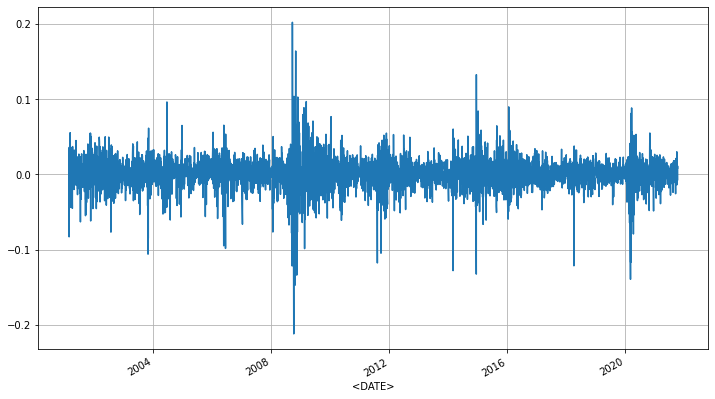

In [9]:
rtsi['log return'].plot(figsize=(12, 7))

plt.grid()
plt.show()

In [10]:
rtsi['log return'].describe()

count    5174.000000
mean        0.000455
std         0.020327
min        -0.211994
25%        -0.008822
50%         0.001318
75%         0.010414
max         0.202039
Name: log return, dtype: float64

In [11]:
rtsi['day of week'] = rtsi.index.dayofweek + 1

In [12]:
rtsi['day of week']

<DATE>
2001-02-18    7
2001-02-19    1
2001-02-20    2
2001-02-21    3
2001-02-22    4
             ..
2021-10-11    1
2021-10-12    2
2021-10-13    3
2021-10-14    4
2021-10-15    5
Name: day of week, Length: 5174, dtype: int64

In [13]:
# rtsi['test triangular cluster memb'] = \
calc_trapezoidal_membership_degrees(rtsi['day of week'].values,
                                    a=[0, 2],
                                    b=[2, 4],
                                    c=[2, 4],
                                    d=[4, 6])

array([0., 0.])

# Setting data & parameters

In [14]:
rescale_factor = 100

In [15]:
start_date = '2010-01-01'

In [16]:
input_data = rtsi['log return'].loc[start_date:].copy() * rescale_factor

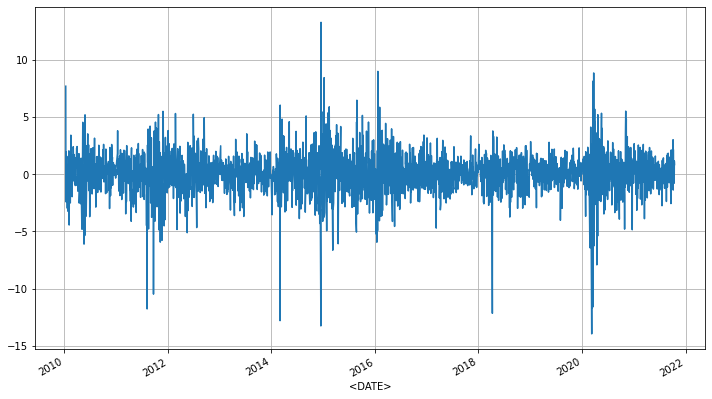

In [17]:
input_data.plot(figsize=(12, 7))

plt.grid()
plt.show()

In [18]:
input_data.describe()

count    2965.000000
mean        0.009091
std         1.772184
min       -13.948614
25%        -0.867805
50%         0.060068
75%         0.920911
max        13.246192
Name: log return, dtype: float64

In [19]:
n = input_data.shape[0]

In [20]:
n

2965

In [21]:
input_data.index.dayofweek + 1

Int64Index([1, 2, 3, 4, 5, 1, 2, 3, 4, 5,
            ...
            1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
           dtype='int64', name='<DATE>', length=2965)

## Train / test split

In [22]:
n_train = 100  # 2000

n_test = 10
n_test = min(n - n_train, n_test)

In [23]:
train, test = input_data.iloc[:n_train].copy(), input_data.iloc[n_train:(n_train + n_test)].copy()
input_cut = pd.concat([train, test]).copy()
# data_to_cluster_train, data_to_cluster_test = days_of_week.iloc[:n_train].copy(), days_of_week.iloc[n_train:].copy()

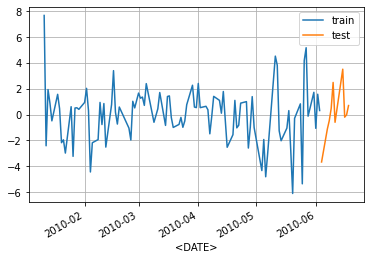

In [24]:
train.plot(label='train')
test.plot(label='test')

plt.legend()
plt.grid()
plt.show()

In [25]:
train.describe()

count    100.000000
mean      -0.033298
std        2.141924
min       -6.113558
25%       -1.051010
50%        0.314542
75%        1.041423
max        7.668616
Name: log return, dtype: float64

## Antecedent parameters

In [26]:
# set #1
clusterization_method_1 = 'trapezoidal'

n_clusters_1 = 2

a = [1, 1]
b = [1, 5]
c = [1, 5]
d = [5, 5]

# set #2
clusterization_method_2 = 'gaussian'

n_clusters_2 = 4

variances = [7, 6, 3, 5]
centers = [-7.5, -1.5, 1.5, 4]

In [27]:
# rtsi['test triangular cluster memb'] = \
calc_trapezoidal_membership_degrees(2,
                                    a=a,
                                    b=b,
                                    c=c,
                                    d=d)

array([0.75, 0.25])

In [28]:
rtsi['day of week']

<DATE>
2001-02-18    7
2001-02-19    1
2001-02-20    2
2001-02-21    3
2001-02-22    4
             ..
2021-10-11    1
2021-10-12    2
2021-10-13    3
2021-10-14    4
2021-10-15    5
Name: day of week, Length: 5174, dtype: int64

In [29]:
clusterization_parameters = [{'a': a, 'b': b, 'c': c, 'd': d, 'n_clusters': n_clusters_1},
                             {'centers': centers, 'variances': variances, 'n_clusters': n_clusters_2}]
clusterization_methods = [clusterization_method_1, clusterization_method_2]
n_clusters = n_clusters_1 * n_clusters_2

## Consequent parameters

In [30]:
# technical parameters for arch_model function
garch_mean = 'Zero'
garch_dist = 'normal'

# general parameters
local_method = 'garch'

# GARCH parameters
p = 1
q = 1

starting_index = max(p, q)

train_sample_std = train.std()
first_h = [train_sample_std ** 2] * starting_index
first_h = np.array(first_h)

# parameters constraints
lower_bounds = [0] * (1 + p + q) * n_clusters
upper_bounds = [+np.inf] * n_clusters + [1] * (p + q) * n_clusters
bounds = (lower_bounds, upper_bounds)

### Using classic GARCH to get initial parameters values

In [31]:
garch = arch_model(train,
                   mean=garch_mean,
                   vol='GARCH',
                   p=p,
                   q=q,
                   dist=garch_dist)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 299.2568988057981
Iteration:      2,   Func. Count:     11,   Neg. LLF: 218.16618783247299
Iteration:      3,   Func. Count:     19,   Neg. LLF: 216.13038589493937
Iteration:      4,   Func. Count:     25,   Neg. LLF: 210.3506174261232
Iteration:      5,   Func. Count:     30,   Neg. LLF: 210.03006916424286
Iteration:      6,   Func. Count:     34,   Neg. LLF: 210.02991627546388
Iteration:      7,   Func. Count:     38,   Neg. LLF: 210.02991515111927
Iteration:      8,   Func. Count:     41,   Neg. LLF: 210.0299151508097
Optimization terminated successfully    (Exit mode 0)
            Current function value: 210.02991515111927
            Iterations: 8
            Function evaluations: 41
            Gradient evaluations: 8


In [32]:
garch_fitted.params

omega       0.176520
alpha[1]    0.116376
beta[1]     0.836795
Name: params, dtype: float64

In [33]:
alpha_0_ini = np.array([garch_fitted.params.iloc[0] for _ in range(n_clusters)])
alpha_ini = np.array([garch_fitted.params.iloc[1:(q + 1)].values for _ in range(n_clusters)])
beta_ini = np.array([garch_fitted.params.iloc[(q + 1):].values for _ in range(n_clusters)])

In [34]:
# alpha_0_ini, alpha_ini, beta_ini = unpack_1d_parameters(garch_fitted.params.values, p=p, q=q, n_clusters=n_clusters)

In [35]:
parameters_ini = {'alpha_0': alpha_0_ini, 'alpha': alpha_ini, 'beta': beta_ini}

In [36]:
parameters_ini

{'alpha_0': array([0.17652034, 0.17652034, 0.17652034, 0.17652034, 0.17652034,
        0.17652034, 0.17652034, 0.17652034]),
 'alpha': array([[0.11637558],
        [0.11637558],
        [0.11637558],
        [0.11637558],
        [0.11637558],
        [0.11637558],
        [0.11637558],
        [0.11637558]]),
 'beta': array([[0.8367954],
        [0.8367954],
        [0.8367954],
        [0.8367954],
        [0.8367954],
        [0.8367954],
        [0.8367954],
        [0.8367954]])}

In [37]:
# # initial parameters values for LS to start with
# alpha_0_ini = np.array([garch_fitted.params.loc['omega']] * n_clusters)
# alpha_ini = np.array([[1] * n_clusters] * q)
# beta_ini = np.array([[1] * n_clusters] * p)
# parameters_ini = {'alpha_0': alpha_0_ini, 'alpha': alpha_ini, 'beta': beta_ini}

In [38]:
list(alpha_ini.flatten())

[0.11637558228349601,
 0.11637558228349601,
 0.11637558228349601,
 0.11637558228349601,
 0.11637558228349601,
 0.11637558228349601,
 0.11637558228349601,
 0.11637558228349601]

### Setting dict w/ all consequent parameters

In [39]:
local_method_parameters = {'p': p, 'q': q, 'mean': garch_mean, 'dist': garch_dist, 'first_h': first_h,
                           'bounds': bounds, 'parameters_ini': parameters_ini}

## Other params

In [40]:
n_last_points_to_use_for_clustering_1 = 1
n_last_points_to_use_for_clustering_2 = 10
n_last_points_to_use_for_clustering = [n_last_points_to_use_for_clustering_1, n_last_points_to_use_for_clustering_2]

In [41]:
data_to_cluster_1 = pd.Series(train.index.dayofweek + 1, index=train.index).copy()
data_to_cluster_2 = 'train'
data_to_cluster = [data_to_cluster_1, data_to_cluster_2]

In [42]:
data_to_cluster

[<DATE>
 2010-01-11    1
 2010-01-12    2
 2010-01-13    3
 2010-01-14    4
 2010-01-15    5
              ..
 2010-05-28    5
 2010-05-31    1
 2010-06-01    2
 2010-06-02    3
 2010-06-03    4
 Name: <DATE>, Length: 100, dtype: int64,
 'train']

In [43]:
cluster_sets_conjunction = 'prod'

# Testing `FuzzyVolatilityModel` class

In [44]:
fvm = FuzzyVolatilityModel(train,
                           clusterization_method=clusterization_methods,
                           clusterization_parameters=clusterization_parameters,
                           local_method=local_method,
                           local_method_parameters=local_method_parameters,
                           n_last_points_to_use_for_clustering=n_last_points_to_use_for_clustering,
                           data_to_cluster=data_to_cluster,
                           cluster_sets_conjunction=cluster_sets_conjunction)

## `fit`

In [45]:
%%time

fvm.fit()

CPU times: user 1min 37s, sys: 6.12 s, total: 1min 44s
Wall time: 1min 49s


In [46]:
n_last_points_to_use_for_clustering

[1, 10]

In [47]:
for i, (_x, _method) in enumerate(zip(data_to_cluster, clusterization_methods)):
    print(n_last_points_to_use_for_clustering[i])

1
10


In [48]:
fvm.alpha_0

array([1.76520343e-01, 3.94894940e-01, 3.79028670e-01, 7.44262775e-01,
       3.60417340e+00, 8.65894298e-01, 1.14810275e-04, 3.51334242e-01],
      dtype=float128)

In [49]:
fvm.alpha

array([[0.995     , 0.09708544, 0.09679388, 0.10106845, 0.95798798,
        0.08932817, 0.08846638, 0.10102531]], dtype=float128)

In [50]:
fvm.beta

array([[0.92224376, 0.80054235, 0.80062418, 0.79918587, 0.8367954 ,
        0.8027686 , 0.80302277, 0.79930352]], dtype=float128)

In [51]:
garch_fitted.params

omega       0.176520
alpha[1]    0.116376
beta[1]     0.836795
Name: params, dtype: float64

In [52]:
fvm._parameters_hist

[{'alpha_0': array([1.76520343e-01, 3.94894940e-01, 3.79028670e-01, 7.44262775e-01,
         3.60417340e+00, 8.65894298e-01, 1.14810275e-04, 3.51334242e-01],
        dtype=float128),
  'alpha': array([[0.995     , 0.09708544, 0.09679388, 0.10106845, 0.95798798,
          0.08932817, 0.08846638, 0.10102531]], dtype=float128),
  'beta': array([[0.92224376, 0.80054235, 0.80062418, 0.79918587, 0.8367954 ,
          0.8027686 , 0.80302277, 0.79930352]], dtype=float128)}]

In [53]:
fvm.membership_degrees_current

array([1.05596817e-32, 1.10203188e-13, 1.18429940e-13, 7.44666139e-17,
       3.16790452e-32, 3.30609563e-13, 3.55289821e-13, 2.23399842e-16],
      dtype=float128)

In [54]:
fvm.clusters_parameters_current

{'n_clusters': 8,
 'params by sets': [{'a': [1, 1],
   'b': [1, 5],
   'c': [1, 5],
   'd': [5, 5],
   'n_clusters': 2},
  {'centers': [-7.5, -1.5, 1.5, 4],
   'variances': [7, 6, 3, 5],
   'n_clusters': 4}]}

In [55]:
data_to_cluster

[<DATE>
 2010-01-11    1
 2010-01-12    2
 2010-01-13    3
 2010-01-14    4
 2010-01-15    5
              ..
 2010-05-28    5
 2010-05-31    1
 2010-06-01    2
 2010-06-02    3
 2010-06-03    4
 Name: <DATE>, Length: 100, dtype: int64,
 'train']

In [56]:
fvm._membership_degrees_hist

[array([1.05596817e-32, 1.10203188e-13, 1.18429940e-13, 7.44666139e-17,
        3.16790452e-32, 3.30609563e-13, 3.55289821e-13, 2.23399842e-16],
       dtype=float128)]

In [57]:
fvm.train_data

<DATE>
2010-01-11    7.668616
2010-01-12   -2.421124
2010-01-13    1.932676
2010-01-14    0.874942
2010-01-15   -0.491052
                ...   
2010-05-28   -0.129833
2010-05-31    1.718848
2010-06-01   -1.069901
2010-06-02    1.570084
2010-06-03    0.310364
Name: log return, Length: 100, dtype: float64

## `forecast`

In [58]:
fvm.forecast()

In [59]:
fvm.current_output

4.894474225146415189

In [60]:
fvm._hist_output

[4.894474225146415189]

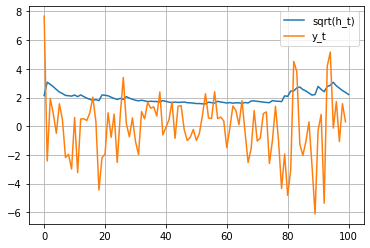

In [61]:
plt.plot(fvm.h ** .5, label='sqrt(h_t)')
plt.plot(train.values, label='y_t')

plt.legend()
plt.grid()
plt.show()

In [62]:
fvm.h

array([4.58784044, 9.43618511, 8.51342795, 7.57977624, 6.56074695,
       5.69549271, 5.2013397 , 4.60182946, 4.53375833, 4.3963977 ,
       4.7469524 , 4.25164078, 4.77439809, 4.26339876, 3.85503243,
       3.51732059, 3.31122259, 3.43977692, 3.17878997, 4.75848533,
       4.66187973, 4.49299816, 4.09413425, 3.74934914, 3.48336939,
       3.78298679, 3.49909398, 4.26552795, 3.83523621, 3.53649354,
       3.27764896, 3.13990395, 3.28360896, 3.13957407, 2.95246095,
       3.02863467, 2.98448782, 2.97014663, 2.83823549, 3.2066747 ,
       3.01539724, 2.82973871, 2.69782093, 2.83760533, 2.7510901 ,
       2.79388237, 2.83974715, 2.69288517, 2.66132905, 2.59858968,
       2.49918647, 2.50396735, 2.44136785, 2.42074647, 2.81871854,
       2.70159556, 2.60323823, 3.02384876, 2.86155134, 2.74238705,
       2.62220294, 2.71662085, 2.59097689, 2.6683286 , 2.65981467,
       2.54473111, 2.73991417, 2.6226476 , 3.09837859, 3.11739857,
       3.01963198, 2.92963441, 2.82276569, 2.74495049, 2.70267

## `feed_daily_data`

In [63]:
n_test_small = 10
test_small = test.iloc[:n_test_small].copy()
input_cut = pd.concat([train, test_small]).copy()

data_to_cluster_test_1 = pd.Series(test_small.index.dayofweek + 1, index=test_small.index).copy()
data_to_cluster_test_2 = 'train'
data_to_cluster_test = [data_to_cluster_test_1, data_to_cluster_test_2]
# data_to_cluster = test_small.index.dayofweek + 1
# data_to_cluster = pd.Series(data_to_cluster, index=test_small.index)

In [64]:
data_to_cluster_test

[<DATE>
 2010-06-04    5
 2010-06-07    1
 2010-06-08    2
 2010-06-09    3
 2010-06-10    4
 2010-06-11    5
 2010-06-15    2
 2010-06-16    3
 2010-06-17    4
 2010-06-18    5
 Name: <DATE>, dtype: int64,
 'train']

In [65]:
fvm._membership_degrees_hist

[array([1.05596817e-32, 1.10203188e-13, 1.18429940e-13, 7.44666139e-17,
        3.16790452e-32, 3.30609563e-13, 3.55289821e-13, 2.23399842e-16],
       dtype=float128)]

In [66]:
%%time

fvm.feed_daily_data(test_small, data_to_cluster=data_to_cluster_test)

CPU times: user 18min 17s, sys: 1min 13s, total: 19min 30s
Wall time: 20min 31s


In [67]:
fvm.data_to_cluster

,<DATE>,log return
<DATE>,,
2010-01-11,1.0,7.668616
2010-01-12,2.0,-2.421124
2010-01-13,3.0,1.932676
2010-01-14,4.0,0.874942
2010-01-15,5.0,-0.491052
...,...,...
2010-06-11,5.0,-0.601688
2010-06-15,2.0,3.508624
2010-06-16,3.0,-0.205114


In [68]:
len(fvm._hist_output)

11

In [69]:
fvm.h

array([4.58784044, 9.28688586, 8.36191895, 7.43320435, 6.42685875,
       5.57482436, 5.08756234, 4.49976462, 4.43133214, 4.29596941,
       4.63630914, 4.15251956, 4.66130142, 4.16253311, 3.7648277 ,
       3.43664267, 3.23707645, 3.363535  , 3.11017119, 4.64960919,
       4.55365759, 4.38786347, 3.99866564, 3.66297865, 3.40461886,
       3.69738379, 3.42119264, 4.16827739, 3.74848452, 3.45769771,
       3.20625663, 3.07307   , 3.21401628, 3.07430395, 2.89278095,
       2.96784079, 2.92542132, 2.91199006, 2.78398429, 3.14337216,
       2.95693443, 2.7763342 , 2.64835113, 2.78509209, 2.70109073,
       2.74311309, 2.78798335, 2.6450503 , 2.61464347, 2.55385988,
       2.45741851, 2.46253534, 2.40193505, 2.38225102, 2.77016115,
       2.65569551, 2.5597893 , 2.96946356, 2.81074088, 2.6944387 ,
       2.57740171, 2.66955853, 2.54720715, 2.62275598, 2.6145079 ,
       2.50248563, 2.69279959, 2.57845468, 3.04182008, 3.05958406,
       2.96373631, 2.8757518 , 2.77156241, 2.69587534, 2.65491

In [70]:
_.shape

(111,)

In [71]:
fvm.data_to_cluster[-10:]

,<DATE>,log return
<DATE>,,
2010-06-04,5.0,-3.674357
2010-06-07,1.0,-1.126682
2010-06-08,2.0,-0.472658
2010-06-09,3.0,0.472658
2010-06-10,4.0,2.482080
2010-06-11,5.0,-0.601688
2010-06-15,2.0,3.508624
2010-06-16,3.0,-0.205114
2010-06-17,4.0,-0.018538


In [72]:
fvm.membership_degrees_hist

,0,1,2,3,4,5,6,7
<DATE>,,,,,,,,
2010-06-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.054911e-31,3.355112e-13,9.348681e-15,5.215794e-18
2010-06-07,4.694184e-30,5.201863e-13,3.194565e-15,1.032514e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2010-06-08,1.432113e-31,1.241369e-12,3.235437e-12,6.757446e-16,4.773711e-32,4.137896e-13,1.078479e-12,2.252482e-16
2010-06-09,1.723399e-29,8.760154e-12,5.961631e-12,1.302162e-16,1.723399e-29,8.760154e-12,5.961631e-12,1.302162e-16
2010-06-10,6.674334e-28,4.762940e-11,2.396740e-11,5.930020e-17,2.002300e-27,1.428882e-10,7.190221e-11,1.779006e-16
2010-06-11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.318387e-27,2.082926e-10,7.148827e-11,1.571037e-16
2010-06-15,2.439717e-28,4.579390e-11,2.758868e-11,1.935323e-16,8.132390e-29,1.526463e-11,9.196226e-12,6.451078e-17
2010-06-16,6.967122e-29,2.696052e-11,3.405932e-11,2.877440e-16,6.967122e-29,2.696052e-11,3.405932e-11,2.877440e-16
2010-06-17,2.278742e-28,2.462553e-11,1.160515e-11,5.165095e-17,6.836226e-28,7.387659e-11,3.481545e-11,1.549528e-16


In [73]:
fvm._membership_degrees_hist

[array([1.05596817e-32, 1.10203188e-13, 1.18429940e-13, 7.44666139e-17,
        3.16790452e-32, 3.30609563e-13, 3.55289821e-13, 2.23399842e-16],
       dtype=float128),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        6.05491147e-31, 3.35511201e-13, 9.34868061e-15, 5.21579393e-18],
       dtype=float128),
 array([4.69418366e-30, 5.20186304e-13, 3.19456453e-15, 1.03251415e-18,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       dtype=float128),
 array([1.43211325e-31, 1.24136885e-12, 3.23543667e-12, 6.75744594e-16,
        4.77371084e-32, 4.13789617e-13, 1.07847889e-12, 2.25248198e-16],
       dtype=float128),
 array([1.72339914e-29, 8.76015437e-12, 5.96163119e-12, 1.30216181e-16,
        1.72339914e-29, 8.76015437e-12, 5.96163119e-12, 1.30216181e-16],
       dtype=float128),
 array([6.67433401e-28, 4.76293975e-11, 2.39674048e-11, 5.93001957e-17,
        2.00230020e-27, 1.42888193e-10, 7.19022145e-11, 1.77900587e-16],
       dty

In [74]:
fvm.hist_output

2010-06-04    4.894474
2010-06-07    6.096479
2010-06-08    5.310314
2010-06-09    4.524295
2010-06-10    3.891806
2010-06-11    4.157693
2010-06-15    3.682698
2010-06-16    4.624308
2010-06-17    4.092745
2010-06-18    3.646051
dtype: float128

In [75]:
test

<DATE>
2010-06-04   -3.674357
2010-06-07   -1.126682
2010-06-08   -0.472658
2010-06-09    0.472658
2010-06-10    2.482080
2010-06-11   -0.601688
2010-06-15    3.508624
2010-06-16   -0.205114
2010-06-17   -0.018538
2010-06-18    0.693539
Name: log return, dtype: float64

In [76]:
fvm.membership_degrees_current

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.88200148e-28, 8.66804612e-11, 5.27318090e-11, 2.70122535e-16],
      dtype=float128)

In [77]:
fvm.clusterization_parameters

[{'a': [1, 1], 'b': [1, 5], 'c': [1, 5], 'd': [5, 5], 'n_clusters': 2},
 {'centers': [-7.5, -1.5, 1.5, 4], 'variances': [7, 6, 3, 5], 'n_clusters': 4}]

In [78]:
fvm._parameters_hist

[{'alpha_0': array([1.76520343e-01, 3.94894940e-01, 3.79028670e-01, 7.44262775e-01,
         3.60417340e+00, 8.65894298e-01, 1.14810275e-04, 3.51334242e-01],
        dtype=float128),
  'alpha': array([[0.995     , 0.09708544, 0.09679388, 0.10106845, 0.95798798,
          0.08932817, 0.08846638, 0.10102531]], dtype=float128),
  'beta': array([[0.92224376, 0.80054235, 0.80062418, 0.79918587, 0.8367954 ,
          0.8027686 , 0.80302277, 0.79930352]], dtype=float128)},
 {'alpha_0': array([1.76520343e-01, 6.49596959e+00, 2.72046522e+00, 3.13988659e-01,
         1.72447463e-01, 1.07376349e-02, 1.10135450e+01, 6.09263061e+00]),
  'alpha': array([[0.11635719, 0.11637468, 0.11637558, 0.11637558, 0.11637558,
          0.08223532, 0.08242727, 0.08302178]]),
  'beta': array([[0.8367954 , 0.8367954 , 0.8367954 , 0.8367954 , 0.8367954 ,
          0.84194267, 0.8410566 , 0.83941725]])},
 {'alpha_0': array([1.76520343e-01, 3.45765545e-01, 4.14105650e-03, 4.02275465e+00,
         6.56778045e-03, 7.693

### Plots

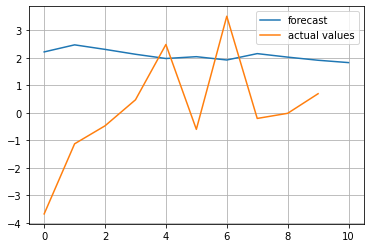

In [79]:
plt.plot((np.array(fvm._hist_output) ** .5), label='forecast')
plt.plot(test_small.values, label='actual values')

plt.legend()
plt.grid()
plt.show()

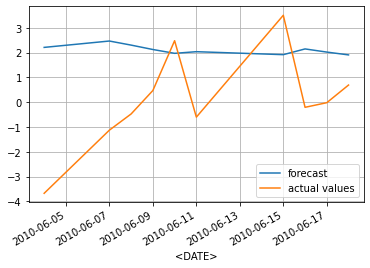

In [80]:
(fvm.hist_output ** .5).plot(label='forecast')
test_small.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

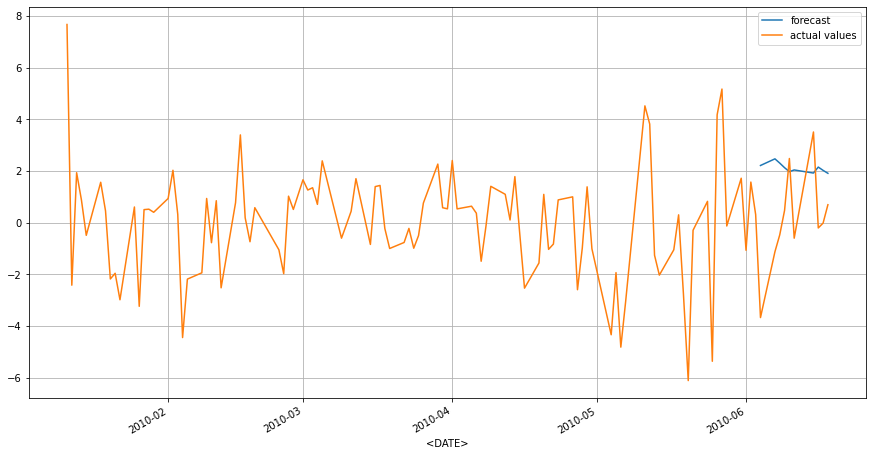

In [81]:
(fvm.hist_output ** .5).plot(label='forecast', figsize=(15, 8))
input_cut.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

### Errors

In [82]:
mean_squared_error(fvm.hist_output ** .5, test_small, squared=True)

7.898680356904104821

In [83]:
mean_squared_error(fvm.hist_output ** .5, test_small, squared=False)

2.8104591007349857574

In [84]:
mean_absolute_percentage_error(fvm.hist_output ** .5, test_small)

1.1222967587239846334

# Model w/o seasoning

In [85]:
lower_bounds_2 = [0] * (1 + p + q) * n_clusters_2
upper_bounds_2 = [+np.inf] * n_clusters_2 + [1] * (p + q) * n_clusters_2
bounds_2 = (lower_bounds_2, upper_bounds_2)

In [86]:
alpha_0_ini_2 = np.array([garch_fitted.params.iloc[0] for _ in range(n_clusters_2)])
alpha_ini_2 = np.array([garch_fitted.params.iloc[1:(q + 1)].values for _ in range(n_clusters_2)])
beta_ini_2 = np.array([garch_fitted.params.iloc[(q + 1):].values for _ in range(n_clusters_2)])

In [87]:
parameters_ini_2 = {'alpha_0': alpha_0_ini_2, 'alpha': alpha_ini_2, 'beta': beta_ini_2}

In [88]:
local_method_parameters_2 = local_method_parameters.copy()
local_method_parameters_2['bounds'] = bounds_2
local_method_parameters_2['parameters_ini'] = parameters_ini_2

In [89]:
fvm_vanilla = FuzzyVolatilityModel(train,
                           clusterization_method=clusterization_methods[1],
                           clusterization_parameters=clusterization_parameters[1],
                           local_method=local_method,
                           local_method_parameters=local_method_parameters_2,
                           n_last_points_to_use_for_clustering=n_last_points_to_use_for_clustering[1],
                           data_to_cluster=data_to_cluster[1],
                           cluster_sets_conjunction=cluster_sets_conjunction)

## `fit`

In [90]:
%%time

fvm_vanilla.fit()

CPU times: user 26.1 s, sys: 1.73 s, total: 27.8 s
Wall time: 30.5 s


In [91]:
n_last_points_to_use_for_clustering

[1, 10]

In [92]:
fvm_vanilla.alpha_0

array([0.17652034, 0.41113012, 0.4111301 , 0.411074  ], dtype=float128)

In [93]:
fvm_vanilla.alpha

array([[0.995     , 0.09101701, 0.09101687, 0.09101824]], dtype=float128)

In [94]:
fvm_vanilla.beta

array([[0.92370759, 0.80182882, 0.80182854, 0.80183659]], dtype=float128)

In [95]:
garch_fitted.params

omega       0.176520
alpha[1]    0.116376
beta[1]     0.836795
Name: params, dtype: float64

In [96]:
fvm_vanilla._parameters_hist

[{'alpha_0': array([0.17652034, 0.41113012, 0.4111301 , 0.411074  ], dtype=float128),
  'alpha': array([[0.995     , 0.09101701, 0.09101687, 0.09101824]], dtype=float128),
  'beta': array([[0.92370759, 0.80182882, 0.80182854, 0.80183659]], dtype=float128)}]

In [97]:
fvm_vanilla.membership_degrees_current

array([4.22387270e-32, 4.40812751e-13, 4.73719761e-13, 2.97866455e-16],
      dtype=float128)

In [98]:
fvm_vanilla.clusters_parameters_current

{'n_clusters': 4,
 'params by sets': [{'centers': [-7.5, -1.5, 1.5, 4],
   'variances': [7, 6, 3, 5],
   'n_clusters': 4}]}

In [99]:
data_to_cluster

[<DATE>
 2010-01-11    1
 2010-01-12    2
 2010-01-13    3
 2010-01-14    4
 2010-01-15    5
              ..
 2010-05-28    5
 2010-05-31    1
 2010-06-01    2
 2010-06-02    3
 2010-06-03    4
 Name: <DATE>, Length: 100, dtype: int64,
 'train']

In [100]:
fvm_vanilla._membership_degrees_hist

[array([4.22387270e-32, 4.40812751e-13, 4.73719761e-13, 2.97866455e-16],
       dtype=float128)]

In [101]:
fvm_vanilla.train_data

<DATE>
2010-01-11    7.668616
2010-01-12   -2.421124
2010-01-13    1.932676
2010-01-14    0.874942
2010-01-15   -0.491052
                ...   
2010-05-28   -0.129833
2010-05-31    1.718848
2010-06-01   -1.069901
2010-06-02    1.570084
2010-06-03    0.310364
Name: log return, Length: 100, dtype: float64

## `forecast`

In [102]:
fvm_vanilla.forecast()

In [103]:
fvm_vanilla.current_output

4.88830892338470232

In [104]:
fvm_vanilla._hist_output

[4.88830892338470232]

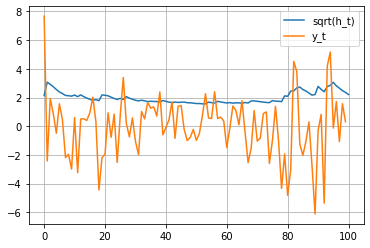

In [105]:
plt.plot(fvm_vanilla.h ** .5, label='sqrt(h_t)')
plt.plot(train.values, label='y_t')

plt.legend()
plt.grid()
plt.show()

In [106]:
fvm_vanilla.h

array([4.58784044, 9.44228663, 8.5157532 , 7.57927486, 6.55808568,
       5.69153839, 5.19703527, 4.59722214, 4.52974216, 4.39278095,
       4.74432513, 4.24862046, 4.77250774, 4.26094243, 3.85237565,
       3.51469073, 3.30886506, 3.4381229 , 3.17716133, 4.75934167,
       4.66217062, 4.49276384, 4.09321793, 3.74804975, 3.48194627,
       3.78226518, 3.4981029 , 4.26575869, 3.83470487, 3.53562343,
       3.27662909, 3.13898259, 3.2831663 , 3.13910593, 2.95194977,
       3.0284765 , 2.98443779, 2.97023254, 2.83828022, 3.20737061,
       3.01579832, 2.82995539, 2.69800331, 2.83814581, 2.75158955,
       2.794538  , 2.84052201, 2.69349326, 2.66198829, 2.59925658,
       2.49982629, 2.50474472, 2.44216641, 2.42163146, 2.82022426,
       2.70283342, 2.60431316, 3.02549373, 2.86279395, 2.74340126,
       2.62306053, 2.71766115, 2.59185428, 2.66936979, 2.66085701,
       2.54563719, 2.74114304, 2.62368168, 3.10005826, 3.11888836,
       3.02081258, 2.93060006, 2.82355799, 2.74566669, 2.70339

## `feed_daily_data`

In [107]:
# n_test_small = 10
# test_small = test.iloc[:n_test_small].copy()
# input_cut = pd.concat([train, test_small]).copy()

# data_to_cluster_test_1 = pd.Series(test_small.index.dayofweek + 1, index=test_small.index).copy()
# data_to_cluster_test_2 = 'train'
# data_to_cluster_test = [data_to_cluster_test_1, data_to_cluster_test_2]

In [108]:
%%time

fvm_vanilla.feed_daily_data(test_small, data_to_cluster=data_to_cluster_test_2)

CPU times: user 4min 38s, sys: 17.1 s, total: 4min 55s
Wall time: 5min 9s


In [109]:
fvm_vanilla.data_to_cluster

<DATE>
2010-01-11    7.668616
2010-01-12   -2.421124
2010-01-13    1.932676
2010-01-14    0.874942
2010-01-15   -0.491052
                ...   
2010-06-11   -0.601688
2010-06-15    3.508624
2010-06-16   -0.205114
2010-06-17   -0.018538
2010-06-18    0.693539
Name: log return, Length: 110, dtype: float64

In [110]:
len(fvm_vanilla._hist_output)

11

In [111]:
fvm_vanilla.h

array([4.58784044, 9.28620028, 8.36153785, 7.43305861, 6.42690361,
       5.57498993, 5.0877639 , 4.50000474, 4.43152283, 4.2961295 ,
       4.63637507, 4.15263179, 4.66130346, 4.16259659, 3.76492103,
       3.43674607, 3.23716626, 3.36356517, 3.1102094 , 4.64939383,
       4.55348904, 4.38774151, 3.99861147, 3.66296729, 3.40462744,
       3.69732665, 3.42116745, 4.16812811, 3.74841075, 3.45766181,
       3.20624257, 3.07305401, 3.21395809, 3.07425365, 2.89274162,
       2.96777163, 2.92534589, 2.91190502, 2.7839079 , 3.14323143,
       2.95682408, 2.77624553, 2.64827051, 2.78497866, 2.70098405,
       2.74299292, 2.78785236, 2.64493807, 2.6145287 , 2.55374715,
       2.45731196, 2.46241821, 2.40181894, 2.38212926, 2.76997612,
       2.65553575, 2.559646  , 2.96925988, 2.81057447, 2.6942945 ,
       2.57727428, 2.66941334, 2.54707945, 2.62261266, 2.61436485,
       2.50235763, 2.69263911, 2.5783138 , 3.04161081, 3.05938852,
       2.96356826, 2.87560369, 2.77143176, 2.69575356, 2.65479

In [112]:
_.shape

(111,)

In [113]:
fvm_vanilla.data_to_cluster[-10:]

<DATE>
2010-06-04   -3.674357
2010-06-07   -1.126682
2010-06-08   -0.472658
2010-06-09    0.472658
2010-06-10    2.482080
2010-06-11   -0.601688
2010-06-15    3.508624
2010-06-16   -0.205114
2010-06-17   -0.018538
2010-06-18    0.693539
Name: log return, dtype: float64

In [114]:
fvm_vanilla.membership_degrees_hist

,0,1,2,3
<DATE>,,,,
2010-06-04,6.054911e-31,3.355112e-13,9.348681e-15,5.215794e-18
2010-06-07,4.694184e-30,5.201863e-13,3.194565e-15,1.032514e-18
2010-06-08,1.909484e-31,1.655158e-12,4.313916e-12,9.009928e-16
2010-06-09,3.446798e-29,1.752031e-11,1.192326e-11,2.604324e-16
2010-06-10,2.669734e-27,1.905176e-10,9.586962e-11,2.372008e-16
2010-06-11,4.318387e-27,2.082926e-10,7.148827e-11,1.571037e-16
2010-06-15,3.252956e-28,6.105854e-11,3.678490e-11,2.580431e-16
2010-06-16,1.393424e-28,5.392105e-11,6.811864e-11,5.754881e-16
2010-06-17,9.114969e-28,9.850212e-11,4.642060e-11,2.066038e-16


In [115]:
fvm_vanilla.hist_output

2010-06-04    4.888309
2010-06-07    6.097469
2010-06-08    5.309465
2010-06-09    4.523872
2010-06-10    3.890516
2010-06-11    4.157587
2010-06-15    3.682842
2010-06-16    4.624858
2010-06-17    4.092650
2010-06-18    3.646007
dtype: float128

In [116]:
test

<DATE>
2010-06-04   -3.674357
2010-06-07   -1.126682
2010-06-08   -0.472658
2010-06-09    0.472658
2010-06-10    2.482080
2010-06-11   -0.601688
2010-06-15    3.508624
2010-06-16   -0.205114
2010-06-17   -0.018538
2010-06-18    0.693539
Name: log return, dtype: float64

In [117]:
fvm_vanilla.membership_degrees_current

array([5.88200148e-28, 8.66804612e-11, 5.27318090e-11, 2.70122535e-16],
      dtype=float128)

In [118]:
fvm_vanilla.clusterization_parameters

{'centers': [-7.5, -1.5, 1.5, 4], 'variances': [7, 6, 3, 5], 'n_clusters': 4}

In [119]:
fvm_vanilla._parameters_hist

[{'alpha_0': array([0.17652034, 0.41113012, 0.4111301 , 0.411074  ], dtype=float128),
  'alpha': array([[0.995     , 0.09101701, 0.09101687, 0.09101824]], dtype=float128),
  'beta': array([[0.92370759, 0.80182882, 0.80182854, 0.80183659]], dtype=float128)},
 {'alpha_0': array([1.76520343e-01, 1.43308757e-04, 1.13828425e+01, 8.65339818e+00],
        dtype=float128),
  'alpha': array([[0.995     , 0.0822186 , 0.08226298, 0.08178608]], dtype=float128),
  'beta': array([[0.99068431, 0.84200473, 0.84195347, 0.84448589]], dtype=float128)},
 {'alpha_0': array([0.17652034, 0.32188598, 3.93881019, 4.07735363], dtype=float128),
  'alpha': array([[0.995376  , 0.08366263, 0.0836825 , 0.08720645]], dtype=float128),
  'beta': array([[0.98399896, 0.82929424, 0.82946988, 0.82821422]], dtype=float128)},
 {'alpha_0': array([0.17652034, 1.37305485, 0.00618053, 1.18129293]),
  'alpha': array([[0.995     , 0.0868447 , 0.08684476, 0.08684019]]),
  'beta': array([[0.79984288, 0.81278755, 0.81280116, 0.812725

### Plots

In [ ]:
plt.plot((np.array(fvm_vanilla._hist_output) ** .5), label='forecast')
plt.plot(test_small.values, label='actual values')

plt.legend()
plt.grid()
plt.show()

In [ ]:
(fvm_vanilla.hist_output ** .5).plot(label='forecast')
test_small.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

In [ ]:
(fvm_vanilla.hist_output ** .5).plot(label='forecast', figsize=(15, 8))
input_cut.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

### Errors

In [ ]:
mean_squared_error(fvm_vanilla.hist_output ** .5, test_small, squared=True)

In [ ]:
_ / mean_squared_error(fvm.hist_output ** .5, test_small, squared=True)

In [ ]:
(_ - 1) * 100

In [ ]:
mean_squared_error(fvm_vanilla.hist_output ** .5, test_small, squared=False)

In [ ]:
mean_absolute_percentage_error(fvm_vanilla.hist_output ** .5, test_small)

## Diff w/ seasonal model

In [ ]:
fvm.h - fvm_vanilla.h

In [ ]:
_.mean()

## Same data fed to GARCH(1, 1)

### No retraining

In [ ]:
model = arch_model(train,
                   mean=local_method_parameters['mean'],
                   vol='GARCH', p=local_method_parameters['p'],
                   q=local_method_parameters['q'],
                   dist=local_method_parameters['dist'])

In [ ]:
model.volatility

In [ ]:
fitted = model.fit()

In [ ]:
fitted.summary

In [ ]:
fitted.params

In [ ]:
fvm.alpha_0

In [ ]:
fvm.alpha

In [ ]:
fvm.beta

In [ ]:
forecast = fitted.forecast(reindex=False, horizon=1)

In [ ]:
forecast_variance = forecast.variance.iloc[0]

In [ ]:
forecast_variance

In [ ]:
simple_garch_forecasts = garch_fitted.forecast(horizon=n_test, reindex=False).variance.iloc[0].values

In [ ]:
mean_squared_error(simple_garch_forecasts, test_small ** 2, squared=True)

### With retraining

In [ ]:
def calc_vanilla_garch_wr_mse(info, data, garch_mean, garch_vol, garch_dist):
    train_size = info.loc['Train size']
    test_size = info.loc['Test size']
    p = info.loc['p']
    q = info.loc['q']
    
    train = data[info.loc['Start date']:].iloc[:train_size]
    test = data[info.loc['Start date']:].iloc[train_size:(train_size + test_size)]
    
    forecast = calculate_retraining_garch_forecasts(train, test,
                                                    mean=garch_mean,
                                                    vol=garch_vol,
                                                    p=p,
                                                    q=q,
                                                    dist=garch_dist)
    
    mse = mean_squared_error(forecast, test ** 2, squared=True)
    
    return mse

# Bollocks

In [ ]:
from multiprocessing import Pool

In [ ]:
def f(length):
    arr = []
    for i in range(int(length)):
        arr.append(i + 1)
    return arr

In [ ]:
%%time

arr = f(1e5)